# 神经网络回归
- https://blog.csdn.net/roguesir/article/details/79383122

In [1]:
# 导入必要的工具包
import time
import numpy as np 
import pandas as pd 
import tensorflow as tf

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
Y_Standard = True
# 生成的结果文件编号
out_name = '%ssummit=0.1-fe-%s.csv'

# path  = '../data/new/'
path_train = '../data/new/train=0.1/'
path_test = '../data/new/test/'
summit_path = '../data/summit/'

## 1 数据准备

In [3]:
train = pd.read_csv(path_train + 'train=0.1-fe.csv')
train.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price
0,2320186,124,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.833333,0.0,0,0.0
1,2959017,121,129429,78242,0,0,6000,0,152480,48626,...,0,0,0,2,2,2,3.166667,0.0,0,0.0
2,242613,122,84839,52467,0,0,0,0,22144,29600,...,0,0,0,0,0,0,2.666667,0.0,0,0.0
3,1416097,136,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
4,680469,104,28625,7200,0,0,0,0,33625,3930,...,0,0,0,0,0,0,1.000000,0.0,0,0.0


In [3]:
test = pd.read_csv(path_test + 'tap_fun_test-fe.csv')
test.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,sr_rss_help_bonus_level,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count
0,14933,94,166415.0,138362.0,0,0,0,0,258522,90142,...,0,0,0,0,1,1,1,8.000000,0.0,0
1,14934,94,10000.0,600.0,0,0,0,0,10000,400,...,0,0,0,0,0,0,0,0.166667,0.0,0
2,14935,94,10000.0,3700.0,0,0,0,0,10000,2000,...,0,0,0,0,0,0,0,17.000000,0.0,0
3,14936,94,210000.0,0.0,200000,0,200000,0,610000,0,...,0,0,0,0,0,0,0,1.666667,0.0,0
4,14937,94,11500.0,3700.0,0,0,0,0,11000,2000,...,0,0,0,0,0,0,0,0.333333,0.0,0


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828934 entries, 0 to 828933
Columns: 108 entries, user_id to pay_count
dtypes: float64(4), int64(104)
memory usage: 683.0 MB


In [5]:
col_int64 = test.select_dtypes(include = ["int64"]).columns
col_float64 = test.select_dtypes(include = ["float64"]).columns
test[col_int64] = test[col_int64].astype(np.int32)
test[col_float64] = test[col_float64].astype(np.float32)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828934 entries, 0 to 828933
Columns: 108 entries, user_id to pay_count
dtypes: float32(4), int32(104)
memory usage: 341.5 MB


In [6]:
test.to_csv(path_test + 'tap_fun_test-fe.csv')

In [7]:
col_float64

Index(['wood_add_value', 'wood_reduce_value', 'avg_online_minutes',
       'pay_price'],
      dtype='object')

In [5]:
# 从原始数据中分离输入特征x和输出y
target = 'prediction_pay_price'
id = 'user_id'
train_y = train[target].values
train_X = train.drop([target, id], axis = 1)

# test_id = test[id]
test_X = test.drop([id], axis = 1)

In [6]:
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(train_X, train_y, random_state=33, test_size=0.1)
print('train.shape=%s X_train_part.shape=%s X_test_part.shape=%s'
      %(train.shape, X_train_part.shape, X_val_part.shape))

train.shape=(228800, 109) X_train_part.shape=(205920, 107) X_test_part.shape=(22880, 107)


## 2 数据标准化

In [7]:
# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
X_train_part = ss_X.fit_transform(X_train_part)
X_val_part = ss_X.transform(X_val_part)
test_X = ss_X.transform(test_X)

if Y_Standard:
    y_train_part = ss_y.fit_transform(y_train_part.reshape(-1, 1))
    y_val_part = ss_y.transform(y_val_part.reshape(-1, 1))

In [8]:
# 标准化数据还原 
def inverse_StandardScaler(predict):
    if Y_Standard:
        predict = ss_y.inverse_transform(predict)
        print('predict = ', predict)
    return predict

#输出预测后的数据
def generate_summit(predict):
    testPredict = test.copy()
    testPredict[target] = predict
    testPredict = testPredict[[id,target]]
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

## 3. 训练模型

In [9]:
# 定义网络结构
n_input = X_train_part.shape[1]
n_output = y_train_part.shape[1]
tf_x = tf.placeholder(tf.float32, [None,n_input])     # input x
tf_y = tf.placeholder(tf.float32, [None,n_output])     # input y

# neural network layers
# layer_dim = [100] #神经元数量=数据维度 
# layer_dim = [107, 10, 1] #添加隐层，调整神经元个数，看看效果 
# layer_dim = [107, 1] 
layer_dim = [107, 50, 1] 

active_fun = tf.nn.relu
# active_fun = tf.nn.relu6 #调整激活函数

for i, dim in enumerate(layer_dim):
    if i == 0: # input_layer
        hidden_layer = tf.layers.dense(tf_x, dim, active_fun) 
    elif i == (len(layer_dim) - 1):
        output_layer = tf.layers.dense(hidden_layer, dim) 
    else:
        hidden_layer = tf.layers.dense(hidden_layer, dim, active_fun)
#     hidden_layer = tf.layers.batch_normalization(hidden_layer) #加快收敛
#     hidden_layer = tf.layers.dropout(hidden_layer, rate=0.5) #防止过拟合

loss = tf.losses.mean_squared_error(tf_y, output_layer)   # compute cost 损失函数 
# 调整优化器和学习率 
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

In [10]:
def model_validation(epoch):
    ''' 模型校验 '''
#     train_loss = sess.run(loss, {tf_x: X_train_part, 
#                                     tf_y: y_train_part})
    val_loss = sess.run(loss, {tf_x: X_val_part, 
                                    tf_y: y_val_part})
    if epoch % 1 == 0:
        print('---------------- epoch=%s  val_loss=%s' % (epoch+1, val_loss))
    
    return val_loss

In [11]:
# 训练参数
n_sample = X_train_part.shape[0]
# batch_size = int(n_sample / 2)
batch_size = 10296
n_step = int(np.ceil(n_sample / batch_size))
n_epoch = 1000
early_stopping_max = 10
early_stopping_threshold = 0.35
print('n_sample=%s batch_size=%s n_step=%s n_epoch=%s' % (n_sample, batch_size, n_step, n_epoch))

n_sample=205920 batch_size=10296 n_step=20 n_epoch=1000


In [12]:
# 进行训练
sess = tf.Session()
sess.run(tf.global_variables_initializer())         # initialize var in graph
loss_train_arr = []
loss_val_arr = []
time_count = []
# losses = []
early_stopping_n = 0

for epoch in range(n_epoch):
    ticks = time.time()
#     print('=============== epoch=%s' % (epoch+1))
    for step in range(n_step):
        # train and net output
        i_from = step * batch_size
        i_to = (step+1) * batch_size
        if i_to > (n_sample - 1): #索引越界处理 
            i_to = (n_sample - 1)
        _, loss_v, pred = sess.run([train_op, loss, output_layer], {tf_x: X_train_part[i_from:i_to], 
                                                         tf_y: y_train_part[i_from:i_to]})
#         losses.append(loss_v)
#         if step % 5 == 0:
#             print('step=%s loss=%s' % (step+1, loss_v))
    mean_loss = loss_v # np.mean(losses)
    loss_train_arr.append(mean_loss)
    val_loss = model_validation(epoch)
    loss_val_arr.append(val_loss)
    ticks = np.round((time.time() - ticks) * 100) / 100
    time_count.append(ticks)
    if epoch % 1 == 0:
        print('%ss/epoch  loss=%s' % (ticks, mean_loss))
    if val_loss < early_stopping_threshold:
        early_stopping_n += 1
    if early_stopping_n > 10:
        break

time_total = np.sum(time_count)
print('time_total=%ss time_epoch=%s'%(time_total, time_count[0]))

---------------- epoch=1  val_loss=1.0814196
0.55s/epoch  loss=0.091568716
---------------- epoch=2  val_loss=0.70732915
0.53s/epoch  loss=0.11614839
---------------- epoch=3  val_loss=1.0415722
0.59s/epoch  loss=0.07907682
---------------- epoch=4  val_loss=0.8330995
0.57s/epoch  loss=0.08270954
---------------- epoch=5  val_loss=0.90195006
0.52s/epoch  loss=0.061076626
---------------- epoch=6  val_loss=0.8764672
0.52s/epoch  loss=0.05880332
---------------- epoch=7  val_loss=0.89657426
0.52s/epoch  loss=0.05167704
---------------- epoch=8  val_loss=0.93897545
0.52s/epoch  loss=0.047530938
---------------- epoch=9  val_loss=0.8354612
0.52s/epoch  loss=0.042459767
---------------- epoch=10  val_loss=0.7690037
0.52s/epoch  loss=0.039788283
---------------- epoch=11  val_loss=0.9628691
0.52s/epoch  loss=0.038078774
---------------- epoch=12  val_loss=1.0409954
0.55s/epoch  loss=0.03934136
---------------- epoch=13  val_loss=0.63551027
0.53s/epoch  loss=0.07503947
---------------- epoch=

---------------- epoch=109  val_loss=0.87279487
0.58s/epoch  loss=0.011120691
---------------- epoch=110  val_loss=0.6376715
0.59s/epoch  loss=0.008513881
---------------- epoch=111  val_loss=0.75840825
0.55s/epoch  loss=0.011501823
---------------- epoch=112  val_loss=0.7264044
0.53s/epoch  loss=0.010074232
---------------- epoch=113  val_loss=0.8121336
0.54s/epoch  loss=0.015926383
---------------- epoch=114  val_loss=0.67097425
0.54s/epoch  loss=0.009539825
---------------- epoch=115  val_loss=0.7601093
0.54s/epoch  loss=0.015724266
---------------- epoch=116  val_loss=0.8225712
0.54s/epoch  loss=0.0105337035
---------------- epoch=117  val_loss=0.7291461
0.54s/epoch  loss=0.011646006
---------------- epoch=118  val_loss=0.71539885
0.58s/epoch  loss=0.01292925
---------------- epoch=119  val_loss=0.79014647
0.54s/epoch  loss=0.009614809
---------------- epoch=120  val_loss=0.7669393
0.53s/epoch  loss=0.010038308
---------------- epoch=121  val_loss=0.7149174
0.52s/epoch  loss=0.0071

---------------- epoch=216  val_loss=0.80875576
0.55s/epoch  loss=0.0051111393
---------------- epoch=217  val_loss=0.8168495
0.54s/epoch  loss=0.005833763
---------------- epoch=218  val_loss=0.76489955
0.52s/epoch  loss=0.005106317
---------------- epoch=219  val_loss=0.78888535
0.52s/epoch  loss=0.004703421
---------------- epoch=220  val_loss=0.7982754
0.52s/epoch  loss=0.0052483333
---------------- epoch=221  val_loss=0.7595017
0.53s/epoch  loss=0.0045052813
---------------- epoch=222  val_loss=0.77104247
0.52s/epoch  loss=0.0043767937
---------------- epoch=223  val_loss=0.8066726
0.51s/epoch  loss=0.005571641
---------------- epoch=224  val_loss=0.7562665
0.52s/epoch  loss=0.0047854753
---------------- epoch=225  val_loss=0.7505724
0.52s/epoch  loss=0.004476546
---------------- epoch=226  val_loss=0.7877864
0.52s/epoch  loss=0.0051222593
---------------- epoch=227  val_loss=0.7377738
0.52s/epoch  loss=0.0040701125
---------------- epoch=228  val_loss=0.7424111
0.52s/epoch  loss=

---------------- epoch=322  val_loss=0.5869785
0.52s/epoch  loss=0.0037878777
---------------- epoch=323  val_loss=0.55344075
0.52s/epoch  loss=0.004514498
---------------- epoch=324  val_loss=0.5903013
0.52s/epoch  loss=0.003571006
---------------- epoch=325  val_loss=0.65127593
0.52s/epoch  loss=0.006408422
---------------- epoch=326  val_loss=0.5624171
0.51s/epoch  loss=0.0041803843
---------------- epoch=327  val_loss=0.557154
0.52s/epoch  loss=0.0069078375
---------------- epoch=328  val_loss=0.6439599
0.52s/epoch  loss=0.0047444203
---------------- epoch=329  val_loss=0.6244936
0.52s/epoch  loss=0.006593956
---------------- epoch=330  val_loss=0.50765514
0.52s/epoch  loss=0.009122805
---------------- epoch=331  val_loss=0.6379358
0.52s/epoch  loss=0.0052145263
---------------- epoch=332  val_loss=0.7619755
0.52s/epoch  loss=0.0061447797
---------------- epoch=333  val_loss=0.54746747
0.51s/epoch  loss=0.0063775973
---------------- epoch=334  val_loss=0.5142734
0.52s/epoch  loss=0

---------------- epoch=428  val_loss=0.7974263
0.52s/epoch  loss=0.0044031534
---------------- epoch=429  val_loss=0.77958643
0.52s/epoch  loss=0.0048859497
---------------- epoch=430  val_loss=0.74824816
0.56s/epoch  loss=0.0058063585
---------------- epoch=431  val_loss=0.77650976
0.57s/epoch  loss=0.0047345636
---------------- epoch=432  val_loss=0.8011346
0.54s/epoch  loss=0.0040365662
---------------- epoch=433  val_loss=0.80236024
0.51s/epoch  loss=0.011374623
---------------- epoch=434  val_loss=0.7209447
0.52s/epoch  loss=0.0048856325
---------------- epoch=435  val_loss=0.73186344
0.51s/epoch  loss=0.010908317
---------------- epoch=436  val_loss=0.7882671
0.52s/epoch  loss=0.0044535086
---------------- epoch=437  val_loss=0.869009
0.51s/epoch  loss=0.02516774
---------------- epoch=438  val_loss=0.744335
0.52s/epoch  loss=0.005236517
---------------- epoch=439  val_loss=0.71208674
0.51s/epoch  loss=0.017084697
---------------- epoch=440  val_loss=0.7731724
0.52s/epoch  loss=0

---------------- epoch=534  val_loss=0.7796905
0.52s/epoch  loss=0.003468254
---------------- epoch=535  val_loss=0.779653
0.51s/epoch  loss=0.01322307
---------------- epoch=536  val_loss=0.82113916
0.52s/epoch  loss=0.0057428908
---------------- epoch=537  val_loss=0.87741053
0.51s/epoch  loss=0.015787555
---------------- epoch=538  val_loss=0.73563325
0.52s/epoch  loss=0.0068728793
---------------- epoch=539  val_loss=0.718352
0.52s/epoch  loss=0.011056465
---------------- epoch=540  val_loss=0.73045194
0.52s/epoch  loss=0.020485993
---------------- epoch=541  val_loss=0.9125895
0.52s/epoch  loss=0.0068488983
---------------- epoch=542  val_loss=0.7623334
0.52s/epoch  loss=0.020530494
---------------- epoch=543  val_loss=0.7204098
0.51s/epoch  loss=0.01081327
---------------- epoch=544  val_loss=0.7714148
0.52s/epoch  loss=0.0120546585
---------------- epoch=545  val_loss=0.8754348
0.51s/epoch  loss=0.0046068924
---------------- epoch=546  val_loss=0.90916896
0.52s/epoch  loss=0.013

---------------- epoch=640  val_loss=0.9254611
0.54s/epoch  loss=0.0024982607
---------------- epoch=641  val_loss=0.9965472
0.54s/epoch  loss=0.0025737598
---------------- epoch=642  val_loss=0.90908474
0.53s/epoch  loss=0.0030754637
---------------- epoch=643  val_loss=0.9785563
0.52s/epoch  loss=0.0028879538
---------------- epoch=644  val_loss=0.9080319
0.52s/epoch  loss=0.0029439759
---------------- epoch=645  val_loss=1.0097518
0.55s/epoch  loss=0.0029296998
---------------- epoch=646  val_loss=0.9060068
0.55s/epoch  loss=0.0029736413
---------------- epoch=647  val_loss=0.9897495
0.54s/epoch  loss=0.0034871195
---------------- epoch=648  val_loss=0.90905344
0.52s/epoch  loss=0.002893675
---------------- epoch=649  val_loss=0.9903564
0.52s/epoch  loss=0.0024219046
---------------- epoch=650  val_loss=0.929215
0.52s/epoch  loss=0.0025004174
---------------- epoch=651  val_loss=0.98507005
0.52s/epoch  loss=0.0029757102
---------------- epoch=652  val_loss=0.93697435
0.52s/epoch  lo

---------------- epoch=745  val_loss=0.9472568
0.52s/epoch  loss=0.0018242201
---------------- epoch=746  val_loss=0.9203878
0.52s/epoch  loss=0.0016042049
---------------- epoch=747  val_loss=0.997419
0.54s/epoch  loss=0.002129317
---------------- epoch=748  val_loss=1.0156302
0.53s/epoch  loss=0.0015327119
---------------- epoch=749  val_loss=0.94947946
0.52s/epoch  loss=0.0022329115
---------------- epoch=750  val_loss=0.9039561
0.52s/epoch  loss=0.0016399336
---------------- epoch=751  val_loss=1.010268
0.52s/epoch  loss=0.0025286495
---------------- epoch=752  val_loss=1.0167115
0.52s/epoch  loss=0.0017101895
---------------- epoch=753  val_loss=0.9334405
0.51s/epoch  loss=0.0026697626
---------------- epoch=754  val_loss=0.8865315
0.52s/epoch  loss=0.0019964739
---------------- epoch=755  val_loss=0.96732724
0.52s/epoch  loss=0.0035951177
---------------- epoch=756  val_loss=0.93008083
0.52s/epoch  loss=0.0022720636
---------------- epoch=757  val_loss=0.8815796
0.52s/epoch  loss

---------------- epoch=850  val_loss=0.7554073
0.53s/epoch  loss=0.0018926552
---------------- epoch=851  val_loss=0.69587547
0.52s/epoch  loss=0.001264603
---------------- epoch=852  val_loss=0.8445395
0.52s/epoch  loss=0.0030671877
---------------- epoch=853  val_loss=0.84082747
0.56s/epoch  loss=0.0016056712
---------------- epoch=854  val_loss=0.7874744
0.52s/epoch  loss=0.003861481
---------------- epoch=855  val_loss=0.7227631
0.52s/epoch  loss=0.003386205
---------------- epoch=856  val_loss=0.9139856
0.52s/epoch  loss=0.00489604
---------------- epoch=857  val_loss=0.8743784
0.52s/epoch  loss=0.0050097015
---------------- epoch=858  val_loss=0.7676704
0.52s/epoch  loss=0.011141655
---------------- epoch=859  val_loss=0.7130465
0.52s/epoch  loss=0.0024803681
---------------- epoch=860  val_loss=0.9340648
0.56s/epoch  loss=0.0069809733
---------------- epoch=861  val_loss=0.82258624
0.56s/epoch  loss=0.002533898
---------------- epoch=862  val_loss=0.87263423
0.52s/epoch  loss=0.

---------------- epoch=955  val_loss=0.76626915
0.52s/epoch  loss=0.0007222904
---------------- epoch=956  val_loss=0.7515512
0.52s/epoch  loss=0.00087486935
---------------- epoch=957  val_loss=0.76477104
0.52s/epoch  loss=0.0007495397
---------------- epoch=958  val_loss=0.7814005
0.52s/epoch  loss=0.0008903204
---------------- epoch=959  val_loss=0.793316
0.52s/epoch  loss=0.00074616756
---------------- epoch=960  val_loss=0.74794865
0.52s/epoch  loss=0.0009004958
---------------- epoch=961  val_loss=0.75887406
0.52s/epoch  loss=0.0006785648
---------------- epoch=962  val_loss=0.79508144
0.52s/epoch  loss=0.00092363916
---------------- epoch=963  val_loss=0.77874917
0.52s/epoch  loss=0.00065668114
---------------- epoch=964  val_loss=0.74254674
0.51s/epoch  loss=0.000988998
---------------- epoch=965  val_loss=0.7437705
0.53s/epoch  loss=0.0007470068
---------------- epoch=966  val_loss=0.79745173
0.53s/epoch  loss=0.0013754033
---------------- epoch=967  val_loss=0.7337888
0.52s/e

## 4. 训练结果可视化

In [13]:
# 训练次数，x 轴
# x = np.arange(0, n_epoch, 1)
x = np.arange(0, len(loss_val_arr), 1)

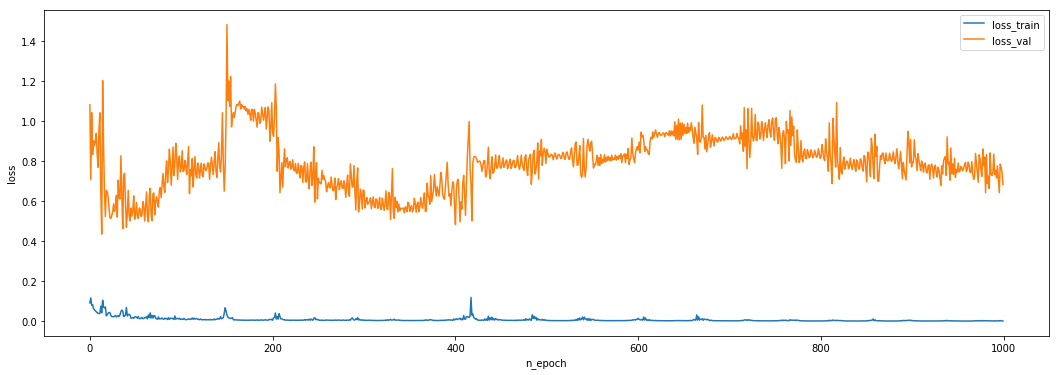

In [14]:
plt.figure(figsize=(18, 6))
# plt.plot(x, loss_train_arr, '-o', label='loss_train')
plt.plot(x, loss_train_arr, '-', label='loss_train')
plt.plot(x, loss_val_arr, '-', label='loss_val')

plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 5. 模型应用

In [15]:
#对测试数据进行预测
test_pred = sess.run(output_layer, {tf_x:test_X})
print('test_pred = ', test_pred)

# 标准化数据还原 
test_pred = inverse_StandardScaler(test_pred)

test_pred =  [[-0.02187181]
 [-0.02187181]
 [-0.02187181]
 ...
 [-0.02187181]
 [-0.02187181]
 [-0.02187181]]
predict =  [[0.18107408]
 [0.18107408]
 [0.18107408]
 ...
 [0.18107408]
 [0.18107408]
 [0.18107408]]


In [16]:
#输出预测后的数据
testPredict = generate_summit(test_pred)
testPredict.to_csv(out_name %(summit_path, 'DNN_V1'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.181074
1,14934,0.181074
2,14935,0.181074
3,14936,0.181074
4,14937,0.181074


In [17]:
# # 最后要关闭 
# sess.close()